<a href="https://colab.research.google.com/github/Uzmamushtaque/Rec_transform/blob/main/bert4rec_movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# from box import Box

import warnings

In [ ]:
config = {
    'data_path' : '/content/ratings.csv',
    'max_len' : 50,
    'hidden_units' : 256, # Embedding size
    'num_heads' : 2, # Multi-head layer
    'num_layers': 2, # block (encoder layer)
    'dropout_rate' : 0.1, # dropout
    'lr' : 0.001,
    'batch_size' : 128,
    'num_epochs' : 10,
    'num_workers' : 2,
    'mask_prob' : 0.15, # for cloze task
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# Dataset

In [ ]:
class MakeSequenceDataSet():
    """
    SequenceData
    """
    def __init__(self, config):
        #self.df = pd.read_csv(os.path.join(config['data_path'], 'rating.csv'))
        self.df = pd.read_csv(config['data_path'])
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('movieId')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('userId')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['movieId'].apply(lambda x : self.item_encoder[x] + 1)
        self.df['user_idx'] = self.df['userId'].apply(lambda x : self.user_encoder[x])
        self.df = self.df.sort_values(['user_idx', 'timestamp'])
        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder

        Args:
            col (str):  columns
        Returns:
            dict: user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder

    def generate_sequence_data(self) -> dict:
        """
        sequence_data

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        group_df = self.df.groupby('user_idx')
        for user, item in group_df:
            users[user].extend(item['item_idx'].tolist())

        for user in users:
            user_train[user] = users[user][:-1]
            user_valid[user] = [users[user][-1]]

        return user_train, user_valid

    def get_train_valid_data(self):
        return self.user_train, self.user_valid

In [ ]:
s = MakeSequenceDataSet(config)

In [ ]:
class BERTRecDataSet(Dataset):
    def __init__(self, user_train, max_len, num_user, num_item, mask_prob):
        self.user_train = user_train
        self.max_len = max_len
        self.num_user = num_user
        self.num_item = num_item
        self.mask_prob = mask_prob
        self._all_items = set([i for i in range(1, self.num_item + 1)])

    def __len__(self):
        #  user sequence
        return self.num_user

    def __getitem__(self, user):

        user_seq = self.user_train[user]
        tokens = []
        labels = []
        for s in user_seq[-self.max_len:]:
            prob = np.random.random()
            if prob < self.mask_prob:
                prob /= self.mask_prob
                if prob < 0.8:
                    # masking
                    tokens.append(self.num_item + 1)  # mask_index: num_item + 1, 0: pad, 1~num_item: item index
                elif prob < 0.9:
                    # noise
                    tokens.extend(self.random_neg_sampling(rated_item = user_seq, num_item_sample = 1))  # item random sampling
                else:
                    tokens.append(s)
                labels.append(s)
            else:
                tokens.append(s)
                labels.append(0)

        mask_len = self.max_len - len(tokens)
        tokens = [0] * mask_len + tokens
        labels = [0] * mask_len + labels

        return torch.LongTensor(tokens), torch.LongTensor(labels)

    def random_neg_sampling(self, rated_item : list, num_item_sample : int):
        nge_samples = random.sample(list(self._all_items - set(rated_item)), num_item_sample)
        return nge_samples

# Model Architecture

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()

        # Compute the positional encodings once in log space.
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size, 1, 1)

class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, embed_size=512):
        super().__init__(vocab_size, embed_size, padding_idx=0)

In [ ]:
class BERTEmbedding(nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)

        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, max_len, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """
        super().__init__()
        self.token = TokenEmbedding(vocab_size=vocab_size, embed_size=embed_size)
        self.position = PositionalEmbedding(max_len=max_len, d_model=embed_size)
        # self.segment = SegmentEmbedding(embed_size=self.token.embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size

    def forward(self, sequence):
        x = self.token(sequence) + self.position(sequence)
        return self.dropout(x)

In [ ]:
b = BERTEmbedding(26744, 768, 150, dropout=0.1)

In [ ]:
b.position.pe

Embedding(150, 768)

In [ ]:
#b.forward(torch.tensor(s.user_train[0]))

In [ ]:
class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """

    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

In [ ]:
class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)

In [ ]:
class GELU(nn.Module):
    """
    Paper Section 3.4, last paragraph notice that BERT used the GELU instead of RELU
    """

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
        :param hidden: hidden size of transformer
        :param attn_heads: head sizes of multi-head attention
        :param feed_forward_hidden: feed_forward_hidden, usually 4*hidden_size
        :param dropout: dropout rate
        """

        super().__init__()
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)

In [ ]:
# from utils import fix_random_seed_as

class BERT(nn.Module):
    def __init__(self, bert_max_len, num_items, bert_num_blocks, bert_num_heads,
                 bert_hidden_units, bert_dropout):
        super().__init__()

        # fix_random_seed_as(args.model_init_seed)
        # self.init_weights()

        max_len = bert_max_len
        num_items = num_items
        n_layers = bert_num_blocks
        heads = bert_num_heads
        vocab_size = num_items + 2
        hidden = bert_hidden_units
        self.hidden = hidden
        dropout = bert_dropout

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=self.hidden, max_len=max_len, dropout=dropout)

        # multi-layers transformer blocks, deep network
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, heads, hidden * 4, dropout) for _ in range(n_layers)])
        self.out = nn.Linear(hidden, num_items + 1)

    def forward(self, x):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x)

        # running over multiple transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        x = self.out(x)
        return x

    def init_weights(self):
        pass

net = BERT(10, 10, 6, 8, 8, 0.4)

# Training

In [ ]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    loss_val = 0
    for seq, labels in tqdm(data_loader):
        seq, labels = seq.to(device), labels.to(device)
        logits = model(seq) # (bs, t, vocab)
        logits = logits.view(-1, logits.size(-1)) # (bs * t, vocab)
        labels = labels.view(-1) # (bs * t)

        optimizer.zero_grad()
        loss = criterion(logits, labels)

        loss_val += loss.item()

        loss.backward()
        optimizer.step()

    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, user_train, user_valid, max_len, data_loader, bert4rec_dataset, make_sequence_dataset):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    num_item_sample = 100

    users = [user for user in range(make_sequence_dataset.num_user)]

    for user in tqdm(users):
        seq = (user_train[user] + [make_sequence_dataset.num_item + 1])[-max_len:] # mask last token
        padding_len = max_len - len(seq)
        seq = [0] * padding_len + seq
        rated = user_train[user] + user_valid[user]
        items = user_valid[user] + bert4rec_dataset.random_neg_sampling(rated_item = rated, num_item_sample = num_item_sample)

        with torch.no_grad():
            seq = torch.LongTensor([seq]).to(device)
            predictions = -model(seq)
#             print(predictions.shape)
            predictions = predictions[0][-1][items] # sampling
#             print(predictions.shape)
            rank = predictions.argsort().argsort()[0].item() # label

        if rank < 10: #Top10
            NDCG += 1 / np.log2(rank + 2)
            HIT += 1

    NDCG /= len(users)
    HIT /= len(users)

    return NDCG, HIT

In [ ]:
make_sequence_dataset = MakeSequenceDataSet(config)

In [ ]:
user_train, user_valid = make_sequence_dataset.get_train_valid_data()

In [ ]:
bert4rec_dataset = BERTRecDataSet(
    user_train = user_train,
    max_len = config['max_len'],
    num_user = make_sequence_dataset.num_user,
    num_item = make_sequence_dataset.num_item,
    mask_prob = config['mask_prob'],
    )

In [ ]:
data_loader = DataLoader(
    bert4rec_dataset,
    batch_size = config['batch_size'],
    shuffle = True,
    pin_memory = True,
    num_workers = config['num_workers'],
    )

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = BERT(
    num_items = 26744,
    bert_hidden_units = config['hidden_units'],
    bert_num_heads = config['num_heads'],
    bert_num_blocks = config['num_layers'],
    bert_max_len = config['max_len'],
    bert_dropout = config['dropout_rate'],
    ).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0) # label (padding)
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
loss_list = []
ndcg_list = []
hit_list = []
for epoch in tqdm(range(1, config['num_epochs'] + 1)):
    train_loss = train(
        model = model,
        criterion = criterion,
        optimizer = optimizer,
        data_loader = data_loader)
    loss_list.append(train_loss)
    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}')

#torch.save(model.state_dict(), os.path.join('/kaggle/working', 'checkpoint.pth'))
torch.save(model.state_dict(), os.path.join('/content/', 'checkpoint.pth'))

  0%|          | 0/5 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

 10%|█         | 1/10 [00:56<08:28, 56.54s/it]

Epoch:   1| Train loss: 10.41426



 20%|██        | 2/10 [01:40<06:31, 48.92s/it]

Epoch:   2| Train loss: 9.57586



 30%|███       | 3/10 [02:23<05:23, 46.18s/it]

Epoch:   3| Train loss: 8.88723



 40%|████      | 4/10 [03:05<04:28, 44.79s/it]

Epoch:   4| Train loss: 8.37904



 50%|█████     | 5/10 [03:48<03:39, 43.96s/it]

Epoch:   5| Train loss: 8.18740



 60%|██████    | 6/10 [04:31<02:54, 43.61s/it]

Epoch:   6| Train loss: 8.02332



 70%|███████   | 7/10 [05:14<02:10, 43.58s/it]

Epoch:   7| Train loss: 7.86853



 80%|████████  | 8/10 [05:59<01:28, 44.06s/it]

Epoch:   8| Train loss: 7.79173



 90%|█████████ | 9/10 [06:42<00:43, 43.68s/it]

Epoch:   9| Train loss: 7.66510



100%|██████████| 10/10 [07:25<00:00, 44.53s/it]

Epoch:  10| Train loss: 7.64647


In [ ]:
ndcg, hit = evaluate(
    model = model,
    user_train = user_train,
    user_valid = user_valid,
    max_len = config['max_len'],
    data_loader = None,
    make_sequence_dataset = make_sequence_dataset,
    bert4rec_dataset = bert4rec_dataset
    )

100%|██████████| 610/610 [00:17<00:00, 35.30it/s]


In [ ]:
print(f'NDCG@10: {ndcg}| HIT@10: {hit}')

NDCG@10: 0.3252641780558016| HIT@10: 0.5311475409836065


ndcg_list is empty. Skipping plotting.


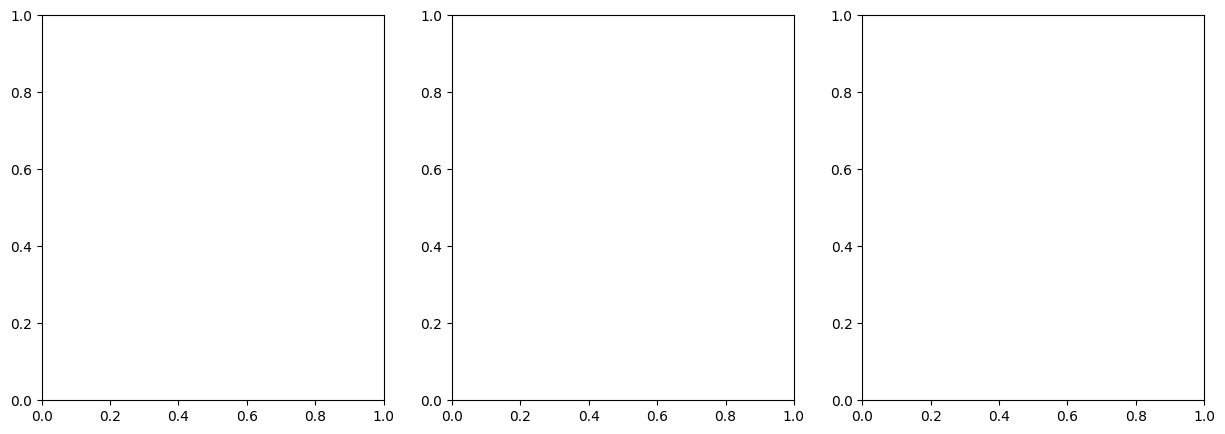

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
epochs = [i for i in range(1, config['num_epochs'] + 1)]
# Check if ndcg_list is empty
if not ndcg_list:
    print("ndcg_list is empty. Skipping plotting.")
else:
    ax[1].plot(epochs, ndcg_list)
    ax[1].set_title('NDCG')

plt.show()

ax[0].plot(epochs, loss_list)
ax[0].set_title('Loss')

#ax[1].plot(epochs, ndcg_list)
#ax[1].set_title('NDCG')

#ax[2].plot(epochs, hit_list)
#ax[2].set_title('HIT')
plt.show()